# Leukemia Classification (C-NMC Dataset)
## Optimized with EfficientNet-style Strategies
This notebook implements a **MobileNetV3-Large** model to classify leukemia cells from the C-NMC dataset. 
It mirrors the robust training strategies found in `9575.ipynb`, including:
*   **Stratified Splits**: train (70%), validation (15%), test (15%) directly from source.
*   **Dual-Phase Training**: Monitors accuracy first, then validation loss.
*   **Aggressive Optimization**: Adamax optimizer, L2 regularization, and dynamic LR reduction.
*   **Architecture**: Enhanced classifier head with Batch Normalization and Dropout.

In [10]:
# Core Libraries
import time
import copy
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Metrics & Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

# Verify Device
device = torch.device("xpu") if torch.xpu.is_available() else torch.device("cpu")
print(f"Using device: {device}")
if torch.xpu.is_available():
    print(f"GPU Name: {torch.xpu.get_device_name(0)}")

Using device: xpu
GPU Name: Intel(R) Arc(TM) B580 Graphics


## 1. Data Loading & Preprocessing
We load the dataset from the `training_data` folder and split it into stratified subsets. This ensures our Validation and Test sets come from the same distribution as the Training set, avoiding domain shift issues found in the provided external validation set.

In [11]:
def load_all_training_data(base_dir="training_data"):
    """
    Loads all image paths and labels from the training directory.
    ALL (Leukemia) is labeled as 1, HEM (Normal) is labeled as 0.
    """
    image_paths = []
    labels = []

    classes = {"all": 1, "hem": 0}

    base_path = Path(base_dir)
    for class_name, label in classes.items():
        class_dir = base_path / class_name
        if not class_dir.exists():
            print(f"Warning: Directory {class_dir} not found.")
            continue

        for img_file in class_dir.glob("*.bmp"):
            image_paths.append(str(img_file.resolve()))
            labels.append(label)

    return image_paths, labels

def create_splits(image_paths, labels):
    # 9575.ipynb uses a 70% Train, 15% Val, 15% Test split (approx)
    # First, split into Train (70%) and Temp (30%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=0.3, stratify=labels, random_state=123
    )
    
    # Split Temp into Val (50% of 30% = 15%) and Test (50% of 30% = 15%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=123
    )
    
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

In [12]:
# Load data and create splits
all_paths, all_labels = load_all_training_data()
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = create_splits(all_paths, all_labels)

# Print Statistics
print("-" * 30)
print(f"Total Images: {len(all_paths)}")
print("-" * 30)
print(f"Training Set:   {len(train_paths):5d} images | {train_labels.count(1):4d} ALL (1) | {train_labels.count(0):4d} HEM (0)")
print(f"Validation Set: {len(val_paths):5d} images | {val_labels.count(1):4d} ALL (1) | {val_labels.count(0):4d} HEM (0)")
print(f"Test Set:       {len(test_paths):5d} images | {test_labels.count(1):4d} ALL (1) | {test_labels.count(0):4d} HEM (0)")
print("-" * 30)

------------------------------
Total Images: 10661
------------------------------
Training Set:    7462 images | 5090 ALL (1) | 2372 HEM (0)
Validation Set:  1599 images | 1091 ALL (1) |  508 HEM (0)
Test Set:        1600 images | 1091 ALL (1) |  509 HEM (0)
------------------------------


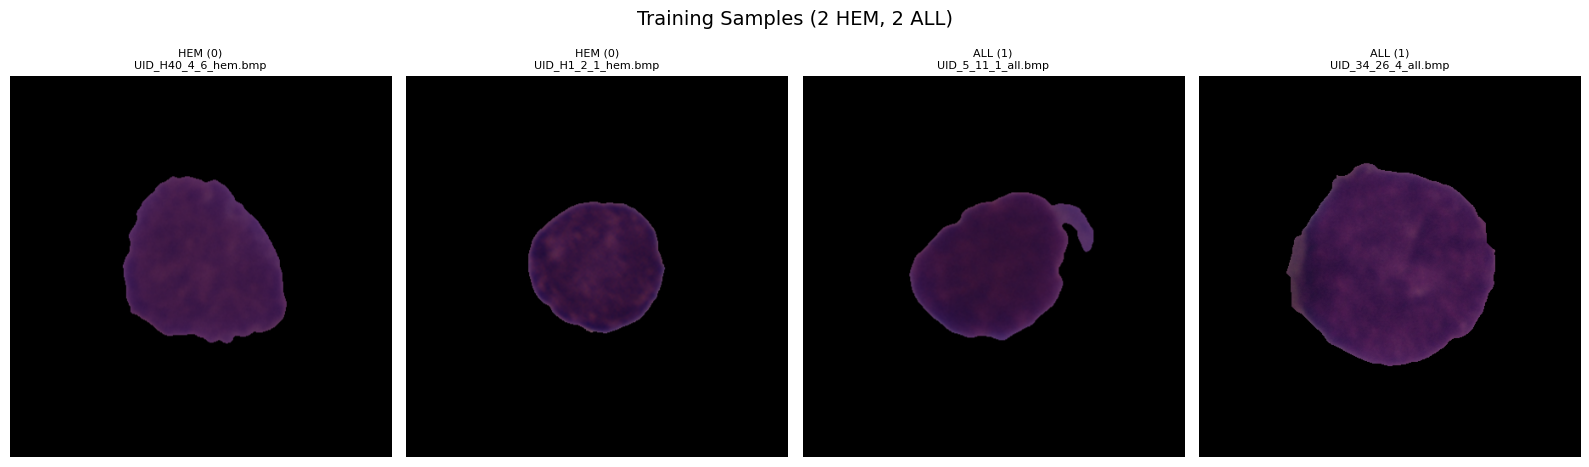

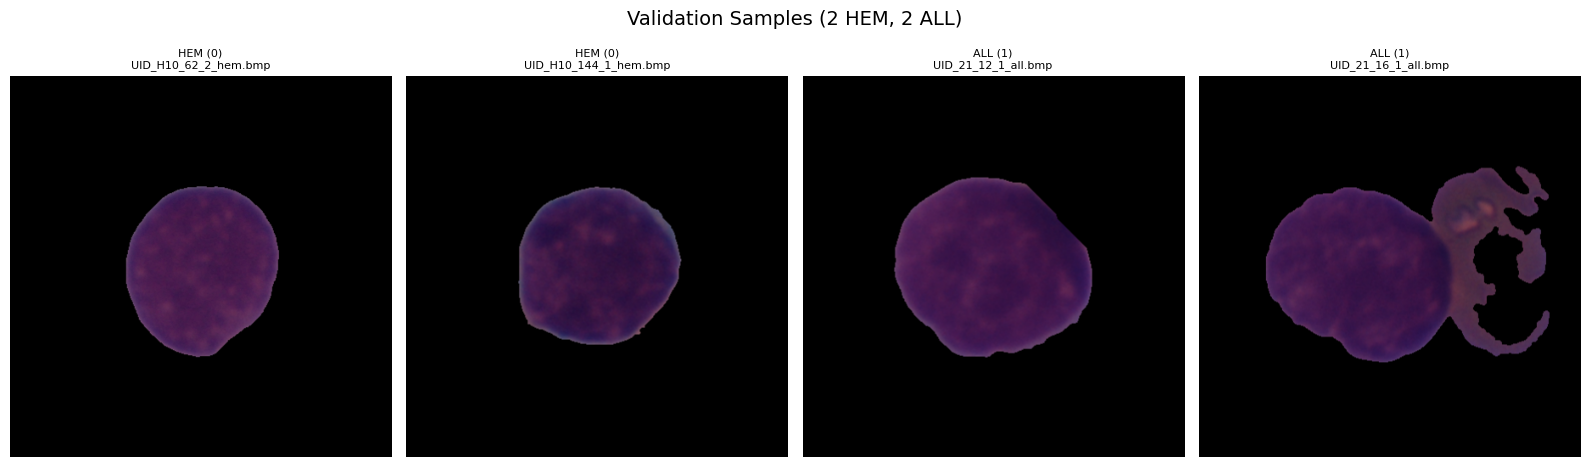

In [13]:
def display_balanced_samples(paths, labels, title, num_per_class=2):
    """
    Displays balanced random samples from each class (0 for HEM, 1 for ALL).
    Includes the filename and label in the title.
    """
    # Group indices by label
    label_groups = {}
    for i, label in enumerate(labels):
        if label not in label_groups:
            label_groups[label] = []
        label_groups[label].append(i)
    
    selected_indices = []
    # Sort labels to ensure consistent order (e.g., 0 then 1)
    for label in sorted(label_groups.keys()):
        indices = label_groups[label]
        selected_indices.extend(random.sample(indices, min(len(indices), num_per_class)))

    if not selected_indices:
        print(f"No samples found to display for {title}.")
        return

    plt.figure(figsize=(16, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, len(selected_indices), i + 1)
        img = Image.open(paths[idx])
        plt.imshow(img)
        
        # Get relative filename for display
        filename = Path(paths[idx]).name
        label_text = "ALL (1)" if labels[idx] == 1 else "HEM (0)"
        
        plt.title(f"{label_text}\n{filename}", fontsize=8)
        plt.axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Display 2 ALL and 2 HEM from training
display_balanced_samples(train_paths, train_labels, "Training Samples (2 HEM, 2 ALL)")

# Display 2 ALL and 2 HEM from validation
display_balanced_samples(val_paths, val_labels, "Validation Samples (2 HEM, 2 ALL)")

In [14]:
# 1. Define Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 40 # Matches 9575.ipynb

# 2. Define Transforms
# Training: Augmentation to prevent overfitting
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test: No augmentation, just resizing and normalization
val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Custom Dataset Class
class LeukemiaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# 4. Create DataLoaders
train_dataset = LeukemiaDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = LeukemiaDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = LeukemiaDataset(test_paths, test_labels, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"DataLoaders Ready. Batch Size: {BATCH_SIZE}")

DataLoaders Ready. Batch Size: 40


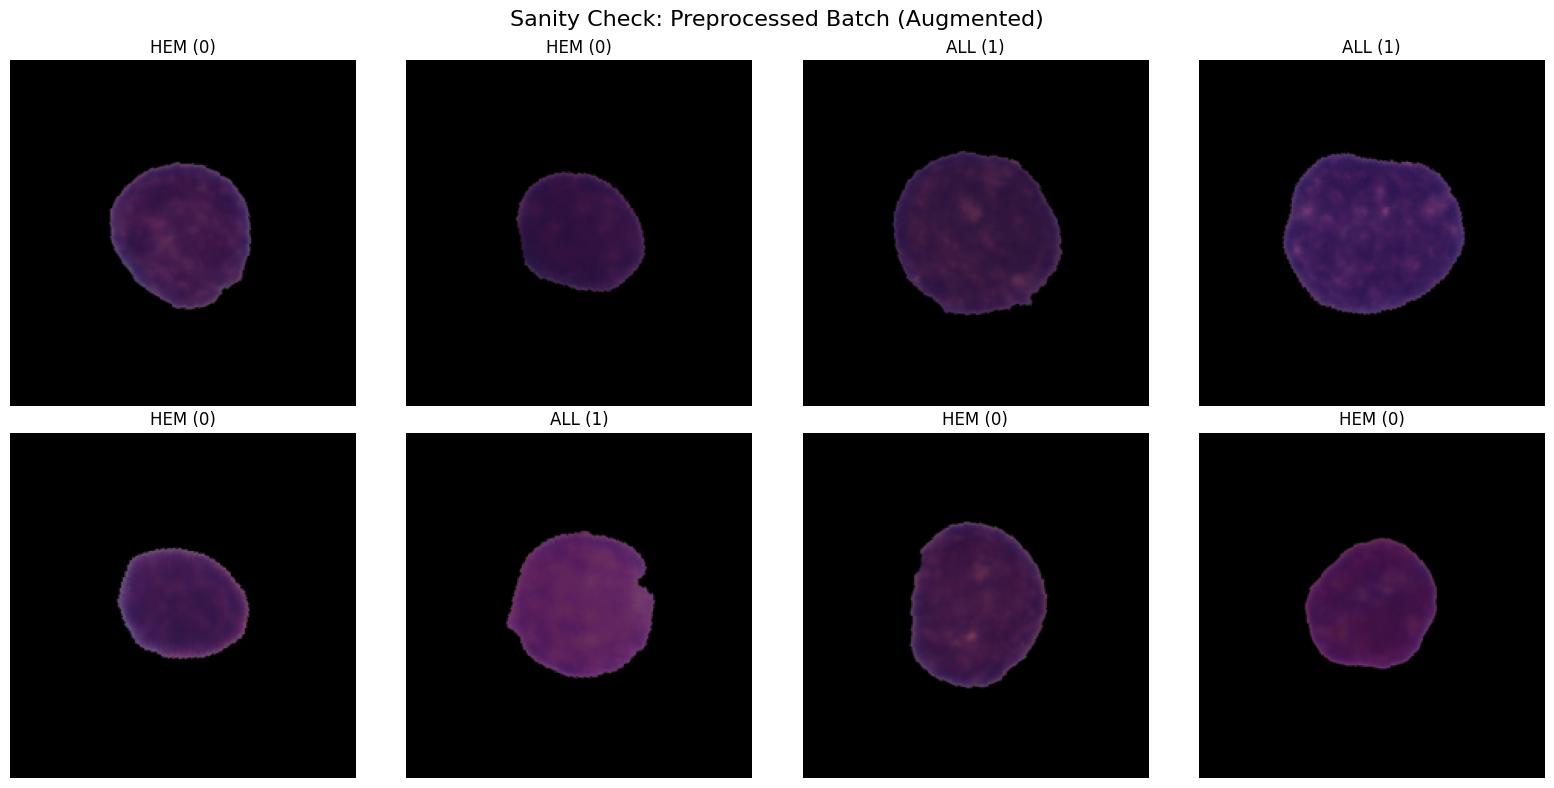

In [15]:
def imshow(img, title=None):
    """Helper function to show a batch of preprocessed tensors."""
    img = img.numpy().transpose((1, 2, 0))
    # Un-normalize for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch
plt.figure(figsize=(16, 8))
for idx in range(min(8, BATCH_SIZE)):
    plt.subplot(2, 4, idx + 1)
    label_text = "ALL (1)" if labels[idx] == 1 else "HEM (0)"
    imshow(images[idx], title=label_text)

plt.suptitle("Sanity Check: Preprocessed Batch (Augmented)", fontsize=16)
plt.tight_layout()
plt.show()

## 2. Model Architecture
We use **MobileNetV3-Large** as the backbone.
The classifier head is reconstructed to match the successful design from `9575.ipynb`, incorporating:
*   **Batch Normalization**: For stable gradients.
*   **Dense Layer (256 units)**: For feature projection.
*   **Dropout (0.45)**: High dropout to separate classes effectively in the latent space.

In [16]:
# 1. Load pre-trained MobileNetV3-Large
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

# 2. Modify Classifier Head
# Structure: BN -> Dense(256) -> ReLU -> Dropout(0.45) -> Dense(2)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(p=0.45),
    nn.Linear(256, 2)
)

model = model.to(device)

# 3. Define Optimizer & Loss
criterion = nn.CrossEntropyLoss()
# Adamax with L2 regularization (weight_decay)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-3)

print("Model: MobileNetV3-Large (Custom Head)")
print(f"Optimizer: Adamax (lr=0.001)")
print("-" * 20)
print(model.classifier)

Model: MobileNetV3-Large (Custom Head)
Optimizer: Adamax (lr=0.001)
--------------------
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Sequential(
    (0): BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1280, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.45, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


## 3. Training Loop
The training process uses a custom callback system that:
1.  **Monitors Accuracy First**: Ensures the model learns the basics (threshold > 0.9).
2.  **Switches to Val Loss**: Optimizes for generalization once accuracy is high.
3.  **Reduces LR**: Cuts learning rate by half if no improvement is seen for 1 epoch.
4.  **Early Stopping**: Halts if learning rate is reduced 3 times without benefit.

In [17]:
class CustomCallback:
    """
    Manages the training lifecycle.
    """
    def __init__(self, model, optimizer, patience=1, stop_patience=3, threshold=0.9, factor=0.5):
        self.model = model
        self.optimizer = optimizer
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.highest_tracc = 0.0
        self.lowest_vloss = float('inf')
        self.best_weights = copy.deepcopy(model.state_dict())
        self.stop_training = False
        
    def on_train_begin(self):
        print("Starting training...")
        print(f"{'Epoch':^8s}{'Train_Loss':^12s}{'Train_Acc':^12s}{'Val_Loss':^12s}{'Val_Acc':^12s}{'LR':^10s}{'Monitor':^12s}{'Duration':^10s}")
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, train_loss, train_acc, val_loss, val_acc, epoch_duration):
        lr = self.optimizer.param_groups[0]['lr']
        monitor = 'val_loss'
        
        # Dual monitoring logic
        if train_acc < self.threshold:
            monitor = 'accuracy'
            if train_acc > self.highest_tracc:
                self.highest_tracc = train_acc
                self.best_weights = copy.deepcopy(self.model.state_dict())
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                self.count += 1
        else:
            monitor = 'val_loss'
            if val_loss < self.lowest_vloss:
                self.lowest_vloss = val_loss
                self.best_weights = copy.deepcopy(self.model.state_dict())
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if train_acc > self.highest_tracc:
                    self.highest_tracc = train_acc
        
        # Adjust LR
        if self.count >= self.patience: 
            next_lr = lr * self.factor
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = next_lr
            self.count = 0 
            self.stop_count += 1
            print(f"\n   >> LR reduced to {next_lr:.6f} (Patience met)")
        
        print(f"{epoch+1:^8d}{train_loss:^12.4f}{train_acc:^12.4f}{val_loss:^12.4f}{val_acc:^12.4f}{lr:^10.5f}{monitor:^12s}{epoch_duration:^10.2f}")

        # Stop training check
        if self.stop_count > self.stop_patience - 1:
            print(f"\n   >> Stopping training: {self.stop_patience} LR reductions with no improvement.")
            self.stop_training = True
            
    def on_train_end(self):
        print(f"Restoring best weights from epoch {self.best_epoch}...")
        self.model.load_state_dict(self.best_weights)
        # Save to disk
        torch.save(self.model.state_dict(), 'best_leukemia_model_weights.pth')
        print("Best model weights saved to 'best_leukemia_model_weights.pth'")


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=40):
    callback = CustomCallback(model, optimizer, patience=1, stop_patience=3, threshold=0.9, factor=0.5)
    callback.on_train_begin()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss_run = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_run += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                
        val_loss = val_loss_run / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        # Callback Step
        callback.on_epoch_end(epoch, train_loss, train_acc.item(), val_loss, val_acc.item(), time.time() - epoch_start)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        if callback.stop_training:
            break
            
    callback.on_train_end()
    return model, history

In [18]:
# Start Training
# We set a high epoch ceiling (40), relying on the callback to stop early if needed.
trained_model, history = train_model(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    num_epochs=40
)

Starting training...
 Epoch   Train_Loss  Train_Acc    Val_Loss    Val_Acc       LR      Monitor    Duration 


Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

   1       0.3985      0.8413      0.4395      0.8130    0.00100    accuracy    46.96   


Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

   2       0.3254      0.8730      0.4443      0.7980    0.00100    accuracy    40.25   


Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

   3       0.2897      0.8847      0.3309      0.8655    0.00100    accuracy    41.56   


Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

   4       0.2657      0.8961      0.3903      0.8255    0.00100    accuracy    41.31   


Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

   5       0.2490      0.9077      0.4820      0.7786    0.00100    val_loss    41.45   


Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

   6       0.2297      0.9137      0.3119      0.9012    0.00100    val_loss    41.56   


Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

   7       0.2143      0.9188      0.2952      0.8768    0.00100    val_loss    41.03   


Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]


   >> LR reduced to 0.000500 (Patience met)
   8       0.2021      0.9252      0.4298      0.7942    0.00100    val_loss    41.63   


Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

   9       0.1795      0.9287      0.2266      0.9162    0.00050    val_loss    41.11   


Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

   10      0.1728      0.9346      0.1728      0.9350    0.00050    val_loss    41.55   


Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]


   >> LR reduced to 0.000250 (Patience met)
   11      0.1659      0.9389      0.1802      0.9337    0.00050    val_loss    41.58   


Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

   12      0.1562      0.9418      0.1504      0.9468    0.00025    val_loss    39.47   


Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

   13      0.1428      0.9475      0.1497      0.9468    0.00025    val_loss    41.30   


Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

   14      0.1436      0.9456      0.1439      0.9462    0.00025    val_loss    40.60   


Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]


   >> LR reduced to 0.000125 (Patience met)
   15      0.1375      0.9500      0.1473      0.9481    0.00025    val_loss    38.10   


Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

   16      0.1265      0.9522      0.1343      0.9493    0.00013    val_loss    37.78   


Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]


   >> LR reduced to 0.000063 (Patience met)
   17      0.1245      0.9546      0.1410      0.9456    0.00013    val_loss    37.99   


Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]


   >> LR reduced to 0.000031 (Patience met)
   18      0.1182      0.9564      0.1520      0.9406    0.00006    val_loss    40.54   


Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]


   >> LR reduced to 0.000016 (Patience met)
   19      0.1133      0.9573      0.1462      0.9425    0.00003    val_loss    40.76   

   >> Stopping training: 3 LR reductions with no improvement.
Restoring best weights from epoch 16...
Best model weights saved to 'best_leukemia_model_weights.pth'


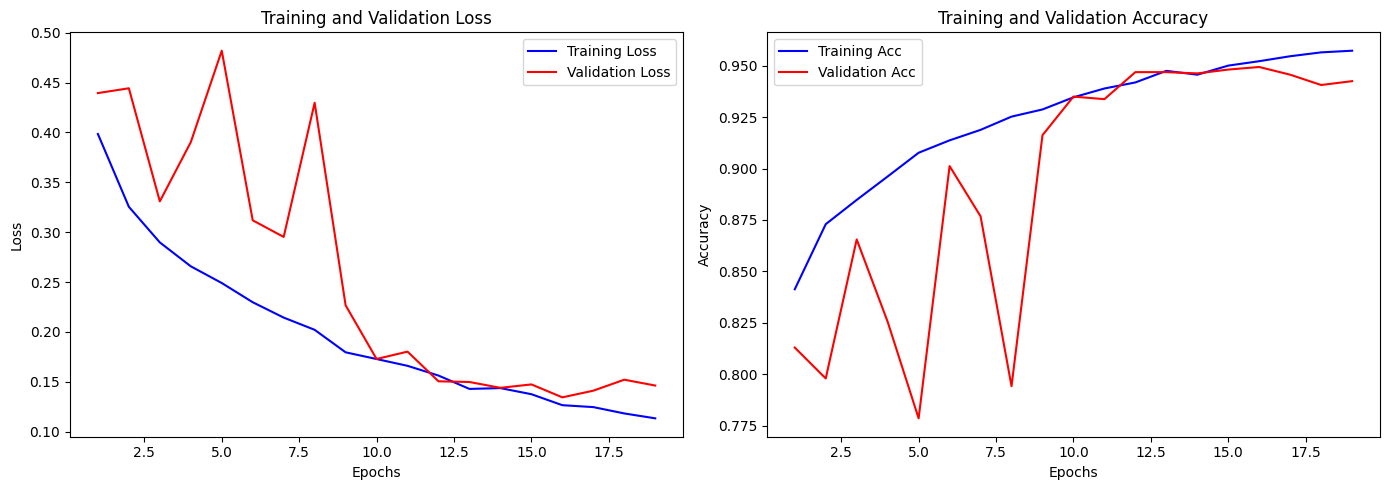

In [19]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)


## 4. Evaluation and Results
Visualization of training progress and final metrics on both Validation and Test sets.

Validation Set:   0%|          | 0/40 [00:00<?, ?it/s]


Classification Report (Validation Set):
              precision    recall  f1-score   support

     HEM (0)       0.93      0.91      0.92       508
     ALL (1)       0.96      0.97      0.96      1091

    accuracy                           0.95      1599
   macro avg       0.94      0.94      0.94      1599
weighted avg       0.95      0.95      0.95      1599



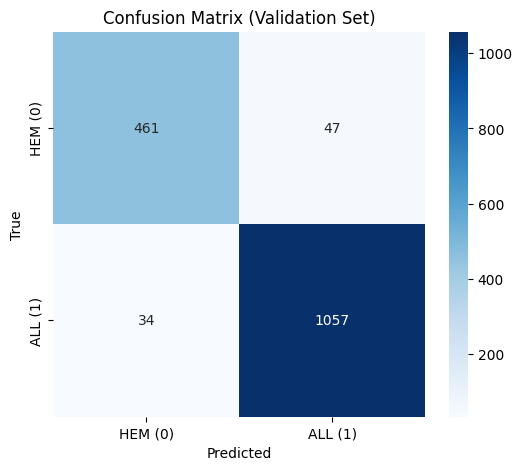

Test Set:   0%|          | 0/40 [00:00<?, ?it/s]


Classification Report (Test Set):
              precision    recall  f1-score   support

     HEM (0)       0.93      0.92      0.92       509
     ALL (1)       0.96      0.97      0.96      1091

    accuracy                           0.95      1600
   macro avg       0.95      0.94      0.94      1600
weighted avg       0.95      0.95      0.95      1600



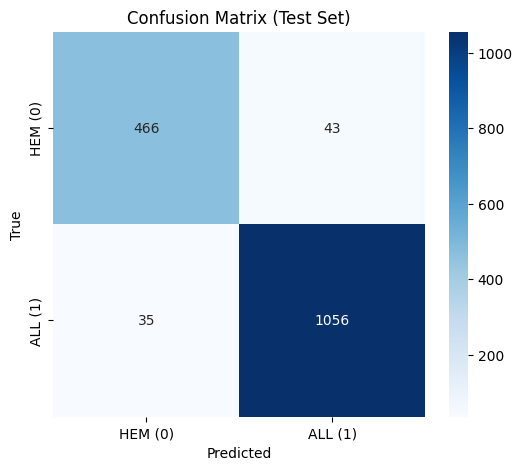

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader, title="Evaluation"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=title):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print(f"\nClassification Report ({title}):")
    print(classification_report(all_labels, all_preds, target_names=["HEM (0)", "ALL (1)"]))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["HEM (0)", "ALL (1)"], 
                yticklabels=["HEM (0)", "ALL (1)"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({title})')
    plt.show()

# Run evaluation on the validation set using the best weights
evaluate_model(trained_model, val_loader, title="Validation Set")

# Run evaluation on the test set using the best weights (Critical for comparison with 9575)
evaluate_model(trained_model, test_loader, title="Test Set")

## 5. Error Analysis
We examine images that were misclassified. Understanding *why* the model fails (e.g., poor image quality, staining artifacts, or ambiguous features) is impactful for medical AI.
Since the Test Loader is not shuffled, we can map predictions back to the original file paths.

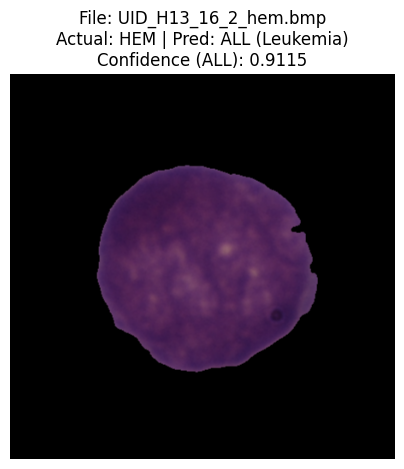

In [75]:
def predict_single_image(model, image_path):
    """
    Predicts the class of a single image path.
    Returns: Class Name, Probability of ALL (Leukemia), and the image.
    """
    model.eval()
    
    # Load and preprocess
    img = Image.open(image_path).convert("RGB")
    
    # Apply the Validation transforms (Resize + Normalize)
    img_tensor = val_test_transforms(img).unsqueeze(0).to(device) # Add batch dimension
    
    with torch.no_grad():
        output = model(img_tensor)
        # Apply Softmax to get probabilities
        probs = torch.nn.functional.softmax(output, dim=1)
        prob_all = probs[0][1].item()
        pred_idx = torch.argmax(probs, dim=1).item()
        
    class_name = "ALL (Leukemia)" if pred_idx == 1 else "HEM (Normal)"
    return class_name, prob_all, img

# Pick a random image from the test set to demo
random_idx = random.randint(0, len(test_paths)-1)
demo_path = test_paths[random_idx]

p_class, p_prob, p_img = predict_single_image(trained_model, demo_path)

# Extract actual label from filename/path for verification
filename = Path(demo_path).name
# Since we know the folder structure implies class, we can imply the ground truth for checking
ground_truth = "ALL" if "all" in str(Path(demo_path).parent).lower() else "HEM"

plt.figure(figsize=(5, 5))
plt.imshow(p_img)
plt.title(f"File: {filename}\nActual: {ground_truth} | Pred: {p_class}\nConfidence (ALL): {p_prob:.4f}")
plt.axis('off')
plt.show()

## 6. Inference Function
A deployment-ready function that takes a raw image path and returns the probability of Leukemia.

Found 21 misclassified samples in scanned batches.


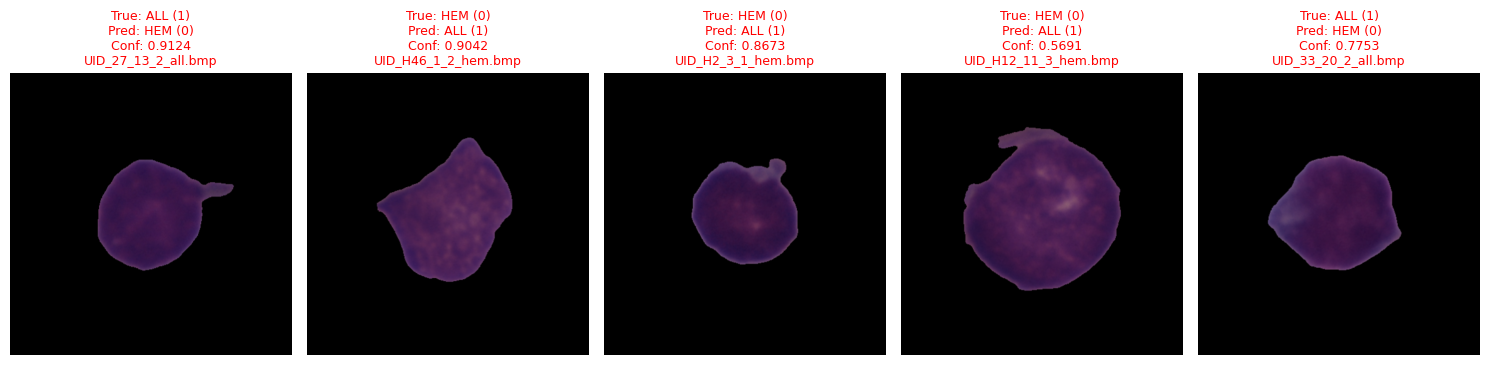

In [89]:
def visualize_misclassifications(model, loader, dataset, num_show=5):
    model.eval()
    misclassified_indices = []
    
    # 1. Find misclassified indices
    current_idx = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get probabilities and predictions
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Compare batch
            mismatches = (preds != labels).cpu().nonzero(as_tuple=True)[0]
            for idx in mismatches:
                global_idx = current_idx + idx.item()
                true_label = labels[idx].item()
                pred_label = preds[idx].item()
                confidence = probs[idx][pred_label].item()
                misclassified_indices.append((global_idx, true_label, pred_label, confidence))
            
            current_idx += inputs.size(0)
            
            # Stop early if we have enough examples
            if len(misclassified_indices) > 20: 
                break
    
    print(f"Found {len(misclassified_indices)} misclassified samples in scanned batches.")
    
    # 2. Plot them
    if not misclassified_indices:
        print("Model is perfect in these batches! No errors to show.")
        return

    num_show = min(num_show, len(misclassified_indices))
    plt.figure(figsize=(15, 5))
    
    for i in range(num_show):
        idx, true_lbl, pred_lbl, conf = misclassified_indices[i]
        path = dataset.image_paths[idx]
        
        plt.subplot(1, num_show, i + 1)
        
        # Open original image to avoid normalization artifacts
        img = Image.open(path)
        plt.imshow(img)
        
        t_text = "ALL (1)" if true_lbl == 1 else "HEM (0)"
        p_text = "ALL (1)" if pred_lbl == 1 else "HEM (0)"
        
        plt.title(f"True: {t_text}\nPred: {p_text}\nConf: {conf:.4f}\n{Path(path).name}", fontsize=9, color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize errors from the Test Set
visualize_misclassifications(trained_model, test_loader, test_dataset)

In [2]:
# Cleanup: release GPU/XPU memory
def cleanup_device(model=None, loaders=None):
    # Move model to CPU and detach from gradients
    if model is not None:
        model.to('cpu')
        model.eval()
        for param in model.parameters():
            param.requires_grad_(False)
    
    # Drop references to DataLoaders to release pinned memory workers
    if loaders:
        for loader in loaders:
            if loader is None:
                continue
            loader.pin_memory = False
        del loaders
    
    # Force garbage collection first
    import gc
    gc.collect()
    
    # Clear CUDA cache if present
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    
    # Clear XPU cache if present (Intel GPU/Arc)
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        torch.xpu.empty_cache()
    
    print('Device caches cleared.')

# Example usage after training:
cleanup_device(model=trained_model, loaders=[train_loader, val_loader, test_loader])

NameError: name 'trained_model' is not defined